In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import pi, c
from scipy import signal

# Ideal point target data generation

In [153]:
# Single moving target

def generate_trajectory(T=20, dt=0.001, v=5, trajectory_type="sinusoidal"):
    """
    Generate a simulated target trajectory. Ideal Point Target.

    Parameters:
        T (float): Total simulation time in seconds.
        dt (float): Time step in seconds / resolution.
        speed (float): Constant speed of the target in m/s.
        trajectory_type (str): Type of trajectory ("linear", "sinusoidal", "random").

        add RCS in dBsm?

    Returns:
        x, y, vx, vy (numpy arrays)
    """

    num_steps = int(T / dt)

    # Initialize arrays for position and velocity
    x = np.zeros(num_steps)
    y = np.zeros(num_steps)

    # Initial position
    x[0], y[0] = 0, 20

    # Generate trajectory based on type
    for i in range(1, num_steps):
        x[i] = x[i-1] + v * dt  # Always move forward in x

        if trajectory_type == "linear":
            y[i] = y[i-1]  # Straight line
        elif trajectory_type == "sinusoidal":
            y[i] = 20 + 10 * np.sin(0.1 * x[i])  # Sine wave path
        elif trajectory_type == "random":
            y[i] = y[i-1] + np.random.uniform(-2, 2)  # Random small movements

    # Calculate velocity
    vx = np.gradient(x, dt)
    vy = np.gradient(y, dt)


    return x, y, vx, vy

def plot_trajectory(x, y, title="Simulated Target Motion"):
    """Plot the trajectory."""
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, label="Ground Truth", color="black")
    plt.xlabel("Range [m]")
    plt.ylabel("Range [m]")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

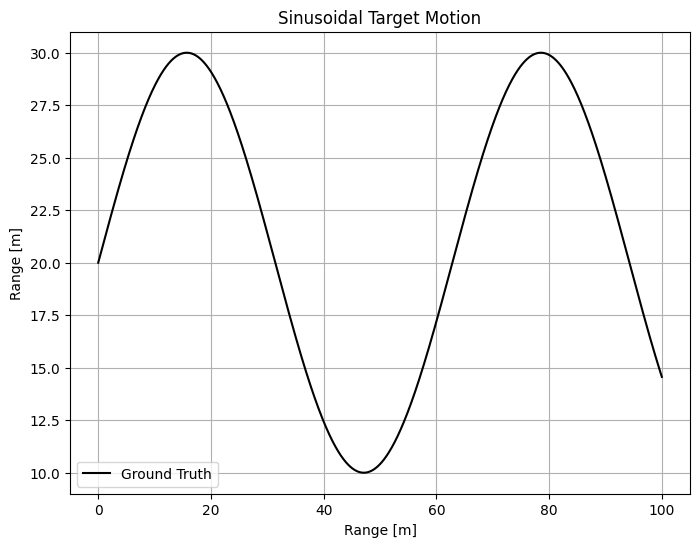

In [154]:
# Example usage
x, y, vx, vy = generate_trajectory(T=20, dt=0.001, v=5, trajectory_type="sinusoidal")
plot_trajectory(x, y, title="Sinusoidal Target Motion")

In [157]:
def radar_to_target(x_target, y_target, x_radar, y_radar, dt=0.001):
    """
    Calculate the range and angle from the radar to the target.

    Parameters:
        x_target, y_target (float): Target position.
        x_radar, y_radar (float): Radar position.

    Returns:
        range (float): Distance from radar to target.
        angle (float): Angle from radar to target.
    """
    N = len(x_target)

    # Initialize arrays for radial range and velocity
    radial_range = np.zeros(N)
    radial_velocity = np.zeros(N)
    
    for i in range(len(x_target)):
        dx = x_target[i] - x_radar
        dy = y_target[i] - y_radar
        radial_range[i] = np.sqrt(dx**2 + dy**2)
        if i == 0:
            radial_velocity[i] = 0
        else:
            radial_velocity[i] = (radial_range[i] - radial_range[i-1]) / dt # radial velocity to target
    return radial_range, radial_velocity

In [158]:
target_range, target_velocity = radar_to_target(x, y, 40, 0, dt=0.001)

# Radar Model

In [3]:
# Single radar setup

f = 76e9 # Hz
Tc = 40e-6 # chirp time - s
bw = 1.5e9 # bandwidth - Hz
chirp_rate = bw/Tc # chirp rate - Hz/s
prf = 1/Tc # pulse repetition frequency - Hz

wavelength = c/f # m
M = 64 # number of chirps

# Single target setup

R = 50 # m
v = 10 # m/s

In [4]:
range_res = c/(2*bw) # m
print(f"Range resolution: {range_res:.2f} m")

Range resolution: 0.10 m


In [5]:
time_from_dist = R/c # s
time_from_vel = 2*(v*Tc)/c # s
time_elapsed = time_from_dist + time_from_vel # s
print(f"Proppagation time: {time_elapsed*1e9:.2f} ns")

Proppagation time: 166.78 ns


In [6]:
time_from_vel

2.6685127615852165e-12

Simulating targets in range and Doppler

In [ ]:
# beat frequency = intermediate frequency

In [41]:
def compute_phase_diff(v):
    time_from_vel = 2*(v*Tc)/c # time shift from chirp to chirp due to velocity!
    return 2*pi*f*time_from_vel

def compute_intermediate_frequency(R):
    return (2*bw*R)/ (c*Tc)


In [111]:
intermediate_freq = compute_intermediate_frequency(target_range[5000]) # Hz
phase_diff = compute_phase_diff(target_velocity[5000]) # rad

print(f"Intermediate frequency: {intermediate_freq/1e6:.2f} MHz")
print(f"Phase delta: {phase_diff:.2f} rad")

Intermediate frequency: 7.51 MHz
Phase delta: -0.76 rad


In [112]:
max_vel = wavelength / (4 * Tc) # m/s
vel_res = wavelength / (2 * M * Tc) # m/s

print(f"Maximum velocity: {max_vel:.2f} m/s")
print(f"Velocity resolution: {vel_res:.2f} m/s")

Maximum velocity: 24.65 m/s
Velocity resolution: 0.77 m/s


In [7]:
max_time = 20 / intermediate_freq # s
N = 10000
Ts = max_time / N # s
fs = 1 / Ts # Hz

t = np.arange(0, max_time, 1 / fs)

if_signal = np.sin(2 * pi * intermediate_freq * t + phase_diff)

plt.plot(t, if_signal)
plt.title(
    f"IF-Signal\n"
    f"$f=\\ ${intermediate_freq/1e6:.2f} MHz, $\\Delta \\phi =\\ ${phase_diff:.2f} rad"
)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

NameError: name 'intermediate_freq' is not defined

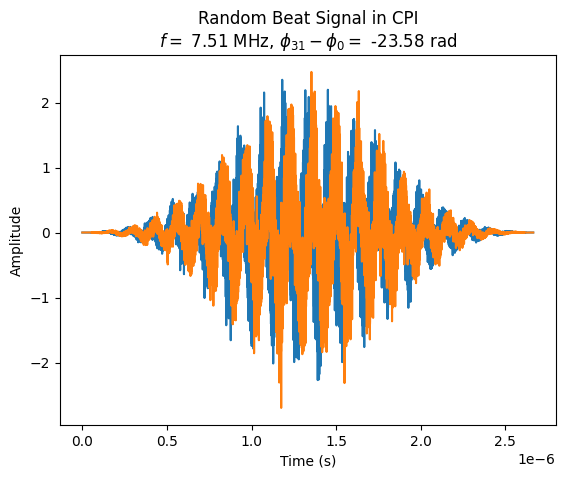

In [148]:
# CPI - Coherent Processing Interval

window = signal.windows.blackman(N)
cpi_single = np.array(
    [
        (
            np.sin(2 * pi * intermediate_freq * t + m * phase_diff)
            + np.random.normal(0, 0.5, N)
        )
        * window
        for m in range(M)
    ]
)

n = np.random.randint(0, M - 1)

plt.plot(t, cpi_single[n])
plt.plot(t, cpi_single[0])
plt.title(
    f"Random Beat Signal in CPI\n"
    f"$f=\\ ${intermediate_freq/1e6:.2f} MHz, $\\phi_{{{n}}} - \\phi_0 =\\ ${n*phase_diff:.2f} rad"
)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

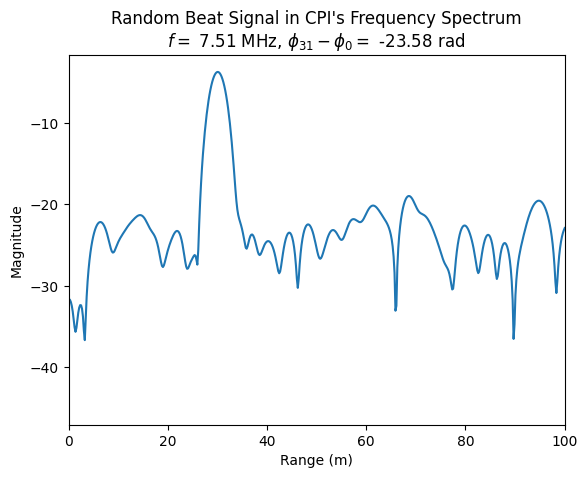

In [149]:
fft_len = N * 8
freq = np.linspace(-fs / 2, fs / 2, fft_len)

rmax = c * Tc * fs / (2 * bw)
n_ranges = np.linspace(-rmax / 2, rmax / 2, N)
ranges = np.linspace(-rmax / 2, rmax / 2, fft_len)

X_k = np.fft.fftshift(np.fft.fft(cpi_single[n], fft_len))
X_k /= N / 2
X_k = np.abs(X_k)
X_k = 10 * np.log10(X_k)

fig, ax = plt.subplots()
ax.set_title(
    f"Random Beat Signal in CPI's Frequency Spectrum\n"
    f"$f=\\ ${intermediate_freq/1e6:.2f} MHz, $\\phi_{{{n}}} - \\phi_0 =\\ ${n*phase_diff:.2f} rad"
)

# Uncomment to plot over frequency axis instead
# ax.plot(freq / 1e6, X_k)
# ax.set_xlabel("Frequency (MHz)")
ax.plot(ranges, X_k)
ax.set_xlabel("Range (m)")

ax.set_ylabel("Magnitude")
ax.set_xlim([0, 100])
plt.show()

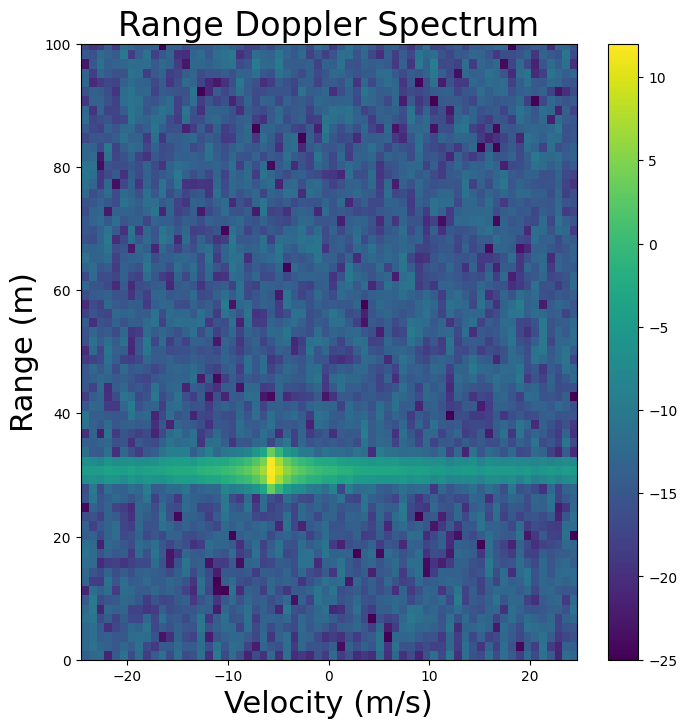

In [150]:
vels = np.linspace(-max_vel, max_vel, M)

range_doppler = np.fft.fftshift(np.abs(np.fft.fft2(cpi_single.T))) / (N / 2)

extent = [-max_vel, max_vel, ranges.min(), ranges.max()]

fig, ax = plt.subplots(figsize=(8, 8))
range_doppler_plot = ax.imshow(
    10 * np.log10(range_doppler),
    aspect="auto",
    extent=extent,
    origin="lower",
    vmax=12,
    vmin=-25,
)
ax.set_ylim([0, 100])
ax.set_title("Range Doppler Spectrum", fontsize=24)
ax.set_xlabel("Velocity (m/s)", fontsize=22)
ax.set_ylabel("Range (m)", fontsize=22)
fig.colorbar(range_doppler_plot)
plt.show()